# Medical Image to Text Report Generation - IU X-Ray Dataset

# 1. Environment Setup
First, let's set up our environment by installing and importing the necessary libraries.

In [2]:
!pip install torch torchvision transformers pillow pandas matplotlib tqdm nltk rouge-score requests beautifulsoup4 

  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24986 sha256=3a6e17eac1de03952eed51dc252ac842be9bedee32c58211e0d887e3bd8c3d78
  Stored in directory: /Users/jaikrishnabollampalli/Library/Caches/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [5]:
# Import necessary libraries
import os
import sys
import requests
import tarfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import re
from collections import Counter

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# NLP imports
from transformers import BertTokenizer
import nltk
nltk.download('punkt')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# Check device 
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Create directories for dataset
DATA_ROOT = "./IUXRAY_DATA"
IMAGE_DIR = os.path.join(DATA_ROOT, "images")
REPORT_DIR = os.path.join(DATA_ROOT, "reports")
TEMP_DIR = os.path.join(DATA_ROOT, "temp")

# Create directories if they don't exist
for directory in [DATA_ROOT, IMAGE_DIR, REPORT_DIR, TEMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    else:
        print(f"Directory already exists: {directory}")

Using device: mps
Created directory: ./IUXRAY_DATA
Created directory: ./IUXRAY_DATA/images
Created directory: ./IUXRAY_DATA/reports
Created directory: ./IUXRAY_DATA/temp


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jaikrishnabollampalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Data Download
Now we'll download the Indiana University Chest X-ray dataset using the direct links provided.

In [13]:
PNG_URL = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"
REPORTS_URL = "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz"
VOCAB_URL = "https://openi.nlm.nih.gov/imgs/collections/radiology_vocabulary_final.xlsx"

def download_file(url, target_path, desc=None):
    """
    Download a file from a URL to a target path with progress bar.
    
    Args:
        url: URL to download from
        target_path: Path to save the file to
        desc: Description for the progress bar
    
    Returns:
        True if download succeeded, False otherwise
    """
    try:
        response = requests.get(url, stream=True)
        
        if response.status_code != 200:
            print(f"Failed to download from {url}: {response.status_code}")
            return False
        
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        
        t = tqdm(total=total_size, unit='iB', unit_scale=True, desc=desc)
        
        with open(target_path, 'wb') as f:
            for data in response.iter_content(block_size):
                t.update(len(data))
                f.write(data)
        
        t.close()
        
        # Check if download was successful (file size match)
        if total_size != 0 and t.n != total_size:
            print(f"Download incomplete: {t.n} / {total_size} bytes")
            return False
            
        return True
    
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return False

def extract_tarfile(tar_path, extract_dir):
    """
    Extract a tar.gz file to a directory.
    
    Args:
        tar_path: Path to the tar.gz file
        extract_dir: Directory to extract to
    
    Returns:
        True if extraction succeeded, False otherwise
    """
    try:
        with tarfile.open(tar_path) as tar:
            # Get total number of members
            members = tar.getmembers()
            total = len(members)
            
            # Extract with progress bar
            for i, member in enumerate(members):
                tar.extract(member, path=extract_dir)
                if i % 100 == 0:  # Update every 100 files
                    sys.stdout.write(f"\rExtracting: {i+1}/{total} files ({(i+1)/total*100:.1f}%)")
                    sys.stdout.flush()
            
            sys.stdout.write(f"\rExtraction completed: {total}/{total} files (100%)\n")
            return True
            
    except Exception as e:
        print(f"Error extracting {tar_path}: {e}")
        return False

def organize_files():
    """
    Organize extracted files into proper directories.
    """
    # Find the extracted directories
    for root, dirs, files in os.walk(TEMP_DIR):
        # Look for PNG images
        for file in files:
            if file.endswith('.png'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(IMAGE_DIR, file)
                
                # Move file
                shutil.move(src_path, dst_path)
                
            # Look for XML reports
            elif file.endswith('.xml'):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(REPORT_DIR, file)
                
                # Move file
                shutil.move(src_path, dst_path)
    
    # Count organized files
    image_count = len([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])
    report_count = len([f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')])
    
    print(f"Organized {image_count} images and {report_count} reports.")
    
    # Clean up temp directory
    shutil.rmtree(TEMP_DIR)
    print(f"Removed temporary directory: {TEMP_DIR}")

# %%
# Download the dataset
def download_dataset():
    """
    Download and organize the IU X-Ray dataset.
    """
    print("Starting download of IU X-Ray dataset...")
    
    # 1. Download PNG images
    png_path = os.path.join(TEMP_DIR, "NLMCXR_png.tgz")
    if os.path.exists(png_path):
        print(f"PNG archive already exists at {png_path}. Skipping download.")
        png_downloaded = True
    else:
        png_downloaded = download_file(PNG_URL, png_path, "Downloading PNG images")
        if png_downloaded:
            print("PNG images downloaded successfully.")
        else:
            print("Failed to download PNG images.")
            return False
    
    # Extract PNG images if needed
    if png_downloaded:
        print("Extracting PNG images...")
        if extract_tarfile(png_path, TEMP_DIR):
            print("PNG images extracted successfully.")
        else:
            print("Failed to extract PNG images.")
            return False
    
    # 2. Download reports
    reports_path = os.path.join(TEMP_DIR, "NLMCXR_reports.tgz")
    if os.path.exists(reports_path):
        print(f"Reports archive already exists at {reports_path}. Skipping download.")
        reports_downloaded = True
    else:
        reports_downloaded = download_file(REPORTS_URL, reports_path, "Downloading reports")
        if reports_downloaded:
            print("Reports downloaded successfully.")
        else:
            print("Failed to download reports.")
            return False
    
    # Extract reports if needed
    if reports_downloaded:
        print("Extracting reports...")
        if extract_tarfile(reports_path, TEMP_DIR):
            print("Reports extracted successfully.")
        else:
            print("Failed to extract reports.")
            return False
    
    # 3. Download vocabulary
    vocab_path = os.path.join(DATA_ROOT, "radiology_vocabulary_final.xlsx")
    if os.path.exists(vocab_path):
        print(f"Vocabulary file already exists at {vocab_path}. Skipping download.")
    else:
        if download_file(VOCAB_URL, vocab_path, "Downloading vocabulary"):
            print("Vocabulary downloaded successfully.")
        else:
            print("Failed to download vocabulary, but continuing with images and reports.")
    
    # 4. Organize files
    print("Organizing files...")
    organize_files()
    
    print("Dataset download and organization completed.")
    return True

# Check if the dataset already exists
def check_dataset_exists():
    """Check if the dataset has already been downloaded and extracted."""
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    report_files = [f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')]
    
    if len(image_files) > 0 and len(report_files) > 0:
        print(f"Dataset already exists with {len(image_files)} images and {len(report_files)} reports.")
        return True
    return False

if not check_dataset_exists():
    print("Dataset not found. Starting download...")
    download_dataset()
else:
    print("Using existing dataset. Skipping download step.")

# download_dataset()


Dataset already exists with 7470 images and 3955 reports.
Using existing dataset. Skipping download step.


## 3. Data Exploration and Preprocessing
 Let's explore the dataset to understand the structure of the images and reports.

Found 7470 images and 3955 reports


Processing reports:   0%|          | 0/3955 [00:00<?, ?it/s]

Created DataFrame with 7470 image-report pairs
Saved dataset info to ./IUXRAY_DATA/dataset_info.csv

Dataset Statistics:
Total number of image-report pairs: 7470
Number of unique images: 7470
Number of unique reports: 3851

Report Length Statistics:
count    7470.000000
mean       39.468675
std        20.273086
min         0.000000
25%        26.000000
50%        36.000000
75%        48.000000
max       232.000000
Name: report_length, dtype: float64


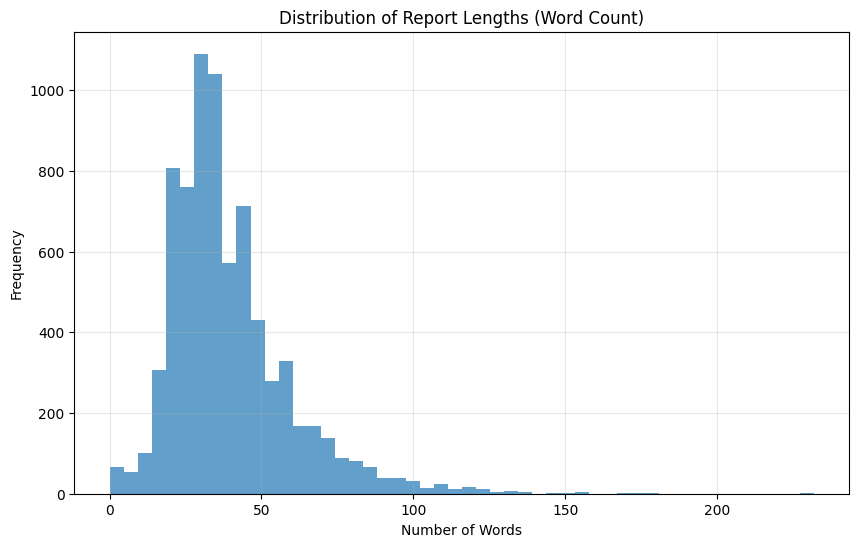


Top 20 Medical Conditions in the Dataset:
normal: 2696
Lung/hypoinflation: 467
Lung/hyperdistention: 318
Cardiomegaly: 269
Cardiomegaly/mild: 245
Aorta/tortuous: 225
Thoracic Vertebrae/degenerative: 212
Spine/degenerative: 208
Granulomatous Disease: 185
Technical Quality of Image Unsatisfactory : 183
Atherosclerosis/aorta: 172
Thoracic Vertebrae/degenerative/mild: 172
No Indexing: 172
Markings/bronchovascular: 132
Calcinosis/aorta: 121
Aorta, Thoracic/tortuous: 102
Emphysema: 99
Spondylosis/thoracic vertebrae: 99
Spine/degenerative/mild: 94
Pulmonary Disease, Chronic Obstructive: 93


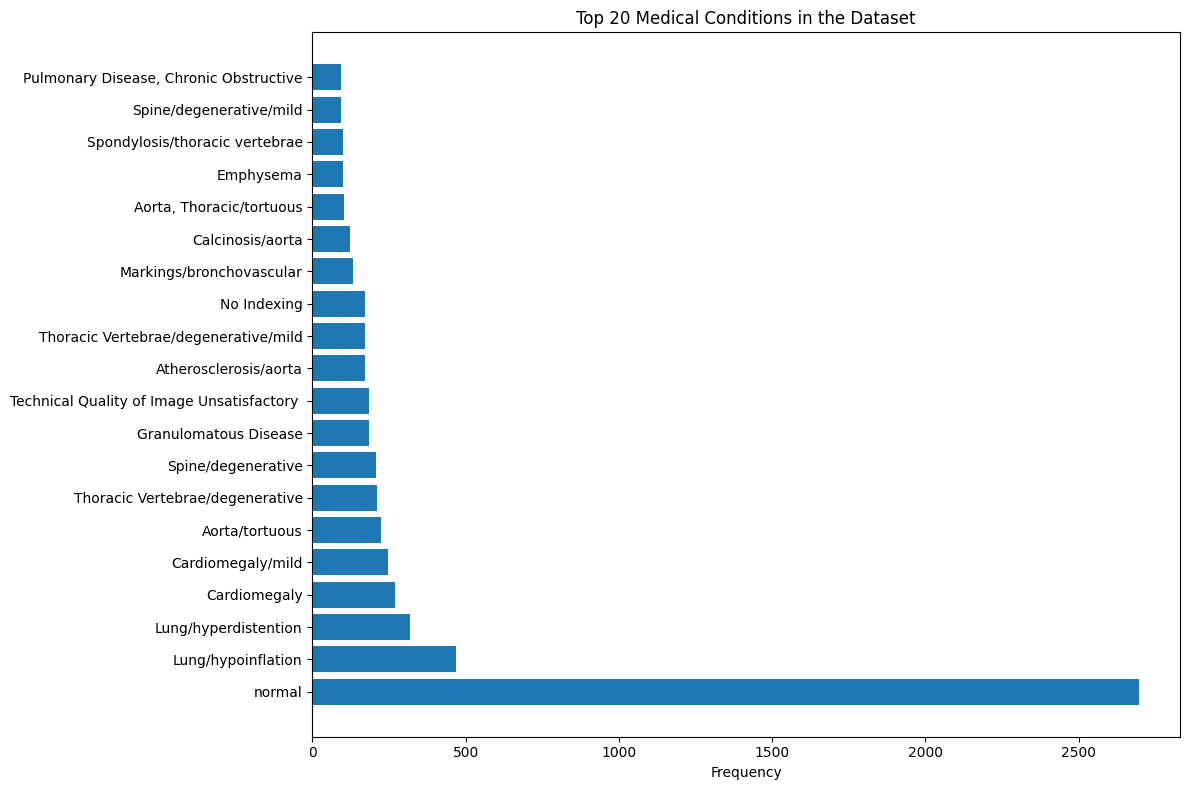

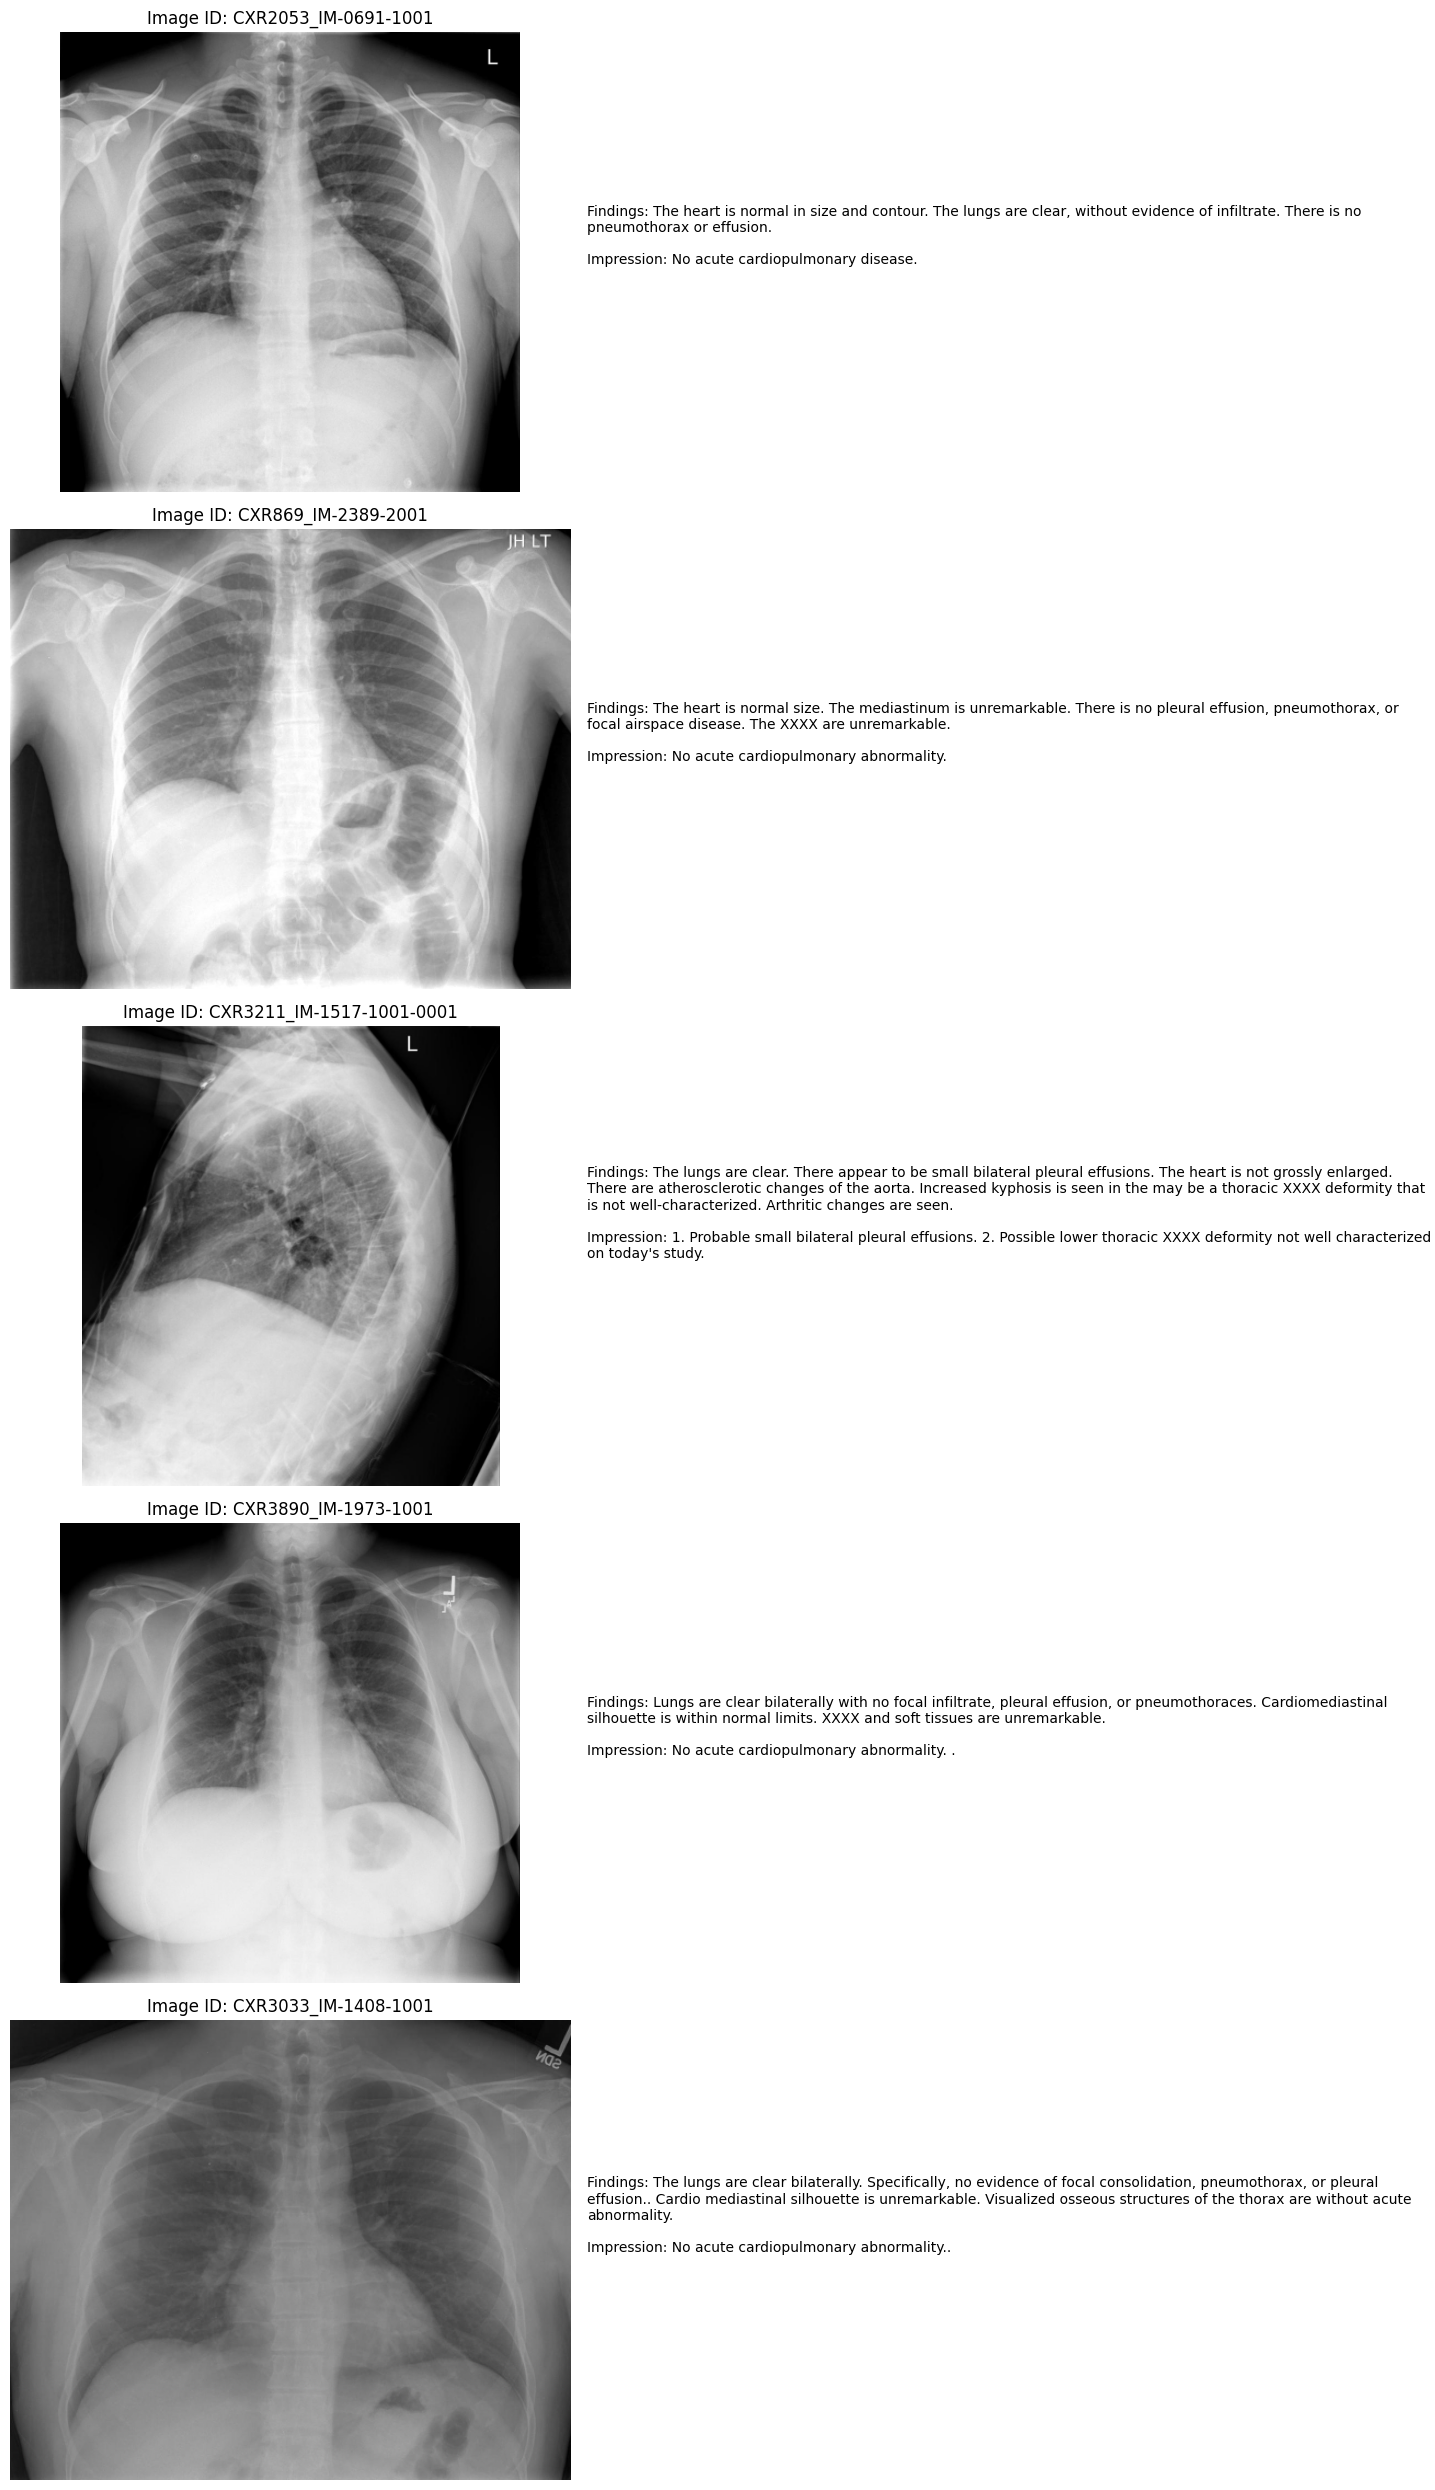

In [19]:
# Function to parse XML reports
def parse_report(xml_path):
    """Parse an XML report file based on the observed structure."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Extract MeSH terms (medical conditions)
        mesh_terms = []
        for mesh in root.findall(".//MeSH/major"):
            if mesh.text:
                mesh_terms.append(mesh.text)
                
        # Extract findings section
        findings_text = ""
        findings = root.find(".//AbstractText[@Label='FINDINGS']")
        if findings is not None and findings.text:
            findings_text = findings.text.strip()
        
        # Extract impression section
        impression_text = ""
        impression = root.find(".//AbstractText[@Label='IMPRESSION']")
        if impression is not None and impression.text:
            impression_text = impression.text.strip()
        
        # Get image IDs associated with this report
        image_ids = []
        for parent_image in root.findall(".//parentImage"):
            if parent_image.get('id'):
                image_ids.append(parent_image.get('id'))
        
        # Combine findings and impression for full report
        full_report = ""
        if findings_text:
            full_report += "FINDINGS: " + findings_text
        if impression_text:
            if full_report:
                full_report += " "
            full_report += "IMPRESSION: " + impression_text
        
        full_report = full_report.strip()
        
        return {
            'mesh_terms': mesh_terms,
            'findings': findings_text,
            'impression': impression_text,
            'full_report': full_report,
            'image_ids': image_ids
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

# %%
# Create dataset DataFrame
def create_dataset_df():
    """Create a DataFrame with image-report pairs."""
    # Get list of all image files
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]
    image_ids = [os.path.splitext(f)[0] for f in image_files]
    image_paths = [os.path.join(IMAGE_DIR, f) for f in image_files]
    
    # Get list of all report files
    report_files = [f for f in os.listdir(REPORT_DIR) if f.endswith('.xml')]
    
    print(f"Found {len(image_files)} images and {len(report_files)} reports")
    
    # Create image dictionary for quick lookup
    image_dict = {img_id: img_path for img_id, img_path in zip(image_ids, image_paths)}
    
    # Parse reports to find image-report pairs
    data = []
    
    for report_file in tqdm(report_files, desc="Processing reports"):
        report_path = os.path.join(REPORT_DIR, report_file)
        report_data = parse_report(report_path)
        
        if report_data:
            # Create entries for each image linked to this report
            for img_id in report_data['image_ids']:
                if img_id in image_dict:
                    item = {
                        'image_id': img_id,
                        'image_path': image_dict[img_id],
                        'report_path': report_path,
                        'mesh_terms': report_data['mesh_terms'],
                        'findings': report_data['findings'],
                        'impression': report_data['impression'],
                        'full_report': report_data['full_report']
                    }
                    data.append(item)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    print(f"Created DataFrame with {len(df)} image-report pairs")
    
    # Save DataFrame
    csv_path = os.path.join(DATA_ROOT, "dataset_info.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved dataset info to {csv_path}")
    
    return df

# %%
# Create the dataset DataFrame
dataset_df = create_dataset_df()

# %%
# Display dataset statistics
print("\nDataset Statistics:")
print(f"Total number of image-report pairs: {len(dataset_df)}")
print(f"Number of unique images: {dataset_df['image_id'].nunique()}")
print(f"Number of unique reports: {dataset_df['report_path'].nunique()}")

# Report length statistics
dataset_df['report_length'] = dataset_df['full_report'].apply(lambda x: len(x.split()) if x else 0)
print("\nReport Length Statistics:")
print(dataset_df['report_length'].describe())

# %%
# Plot distribution of report lengths
plt.figure(figsize=(10, 6))
plt.hist(dataset_df['report_length'], bins=50, alpha=0.7)
plt.title('Distribution of Report Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# %%
# Analyze medical conditions (MeSH terms)
all_mesh_terms = []
for terms in dataset_df['mesh_terms']:
    if isinstance(terms, list):
        all_mesh_terms.extend(terms)

mesh_counter = Counter(all_mesh_terms)
top_conditions = mesh_counter.most_common(20)

print("\nTop 20 Medical Conditions in the Dataset:")
for condition, count in top_conditions:
    print(f"{condition}: {count}")

# %%
# Plot top conditions
plt.figure(figsize=(12, 8))
if top_conditions:  # Only plot if we have conditions
    conditions, counts = zip(*top_conditions)
    plt.barh(conditions, counts)
    plt.title('Top 20 Medical Conditions in the Dataset')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# %%
# Display sample images with reports
def display_samples(df, n=5):
    """Display sample images with their reports."""
    # Filter out empty reports
    non_empty_df = df[df['full_report'] != '']
    if len(non_empty_df) == 0:
        print("No non-empty reports found to display.")
        return
    
    samples = non_empty_df.sample(min(n, len(non_empty_df)))
    
    fig, axes = plt.subplots(n, 2, figsize=(15, 5*n))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            # Display image
            img = Image.open(row['image_path'])
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].set_title(f"Image ID: {row['image_id']}")
            axes[i, 0].axis('off')
            
            # Display report text
            findings = row['findings'] if row['findings'] else "No findings reported."
            impression = row['impression'] if row['impression'] else "No impression reported."
            
            report_text = f"Findings: {findings}\n\n"
            report_text += f"Impression: {impression}"
            
            axes[i, 1].text(0, 0.5, report_text, fontsize=10, wrap=True)
            axes[i, 1].axis('off')
            
        except Exception as e:
            print(f"Error displaying sample {i}: {e}")
    
    plt.tight_layout()
    plt.show()

# %%
# Display samples
display_samples(dataset_df)

# Data split

In [120]:
# Split the dataset into train, validation, and test sets
def split_dataset(df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, random_state=SEED):
    """
    Split the dataset into training, validation, and test sets.
    
    Args:
        df: The DataFrame to split
        train_ratio: Proportion of data for training
        val_ratio: Proportion of data for validation
        test_ratio: Proportion of data for testing
        random_state: Random seed for reproducibility
    
    Returns:
        train_df, val_df, test_df: The split DataFrames
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-10, "Ratios must sum to 1"
    
    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=random_state)
    
    # Calculate split points
    n = len(df_shuffled)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)
    
    # Split the DataFrame
    train_df = df_shuffled.iloc[:train_end].copy()
    val_df = df_shuffled.iloc[train_end:val_end].copy()
    test_df = df_shuffled.iloc[val_end:].copy()
    
    print(f"Dataset split: {len(train_df)} training, {len(val_df)} validation, {len(test_df)} test samples")
    
    return train_df, val_df, test_df

# Remove entries with empty reports
filtered_df = dataset_df[dataset_df['full_report'] != ''].copy()
print(f"Using {len(filtered_df)} entries with non-empty reports for model training")

# Split the dataset
train_df, val_df, test_df = split_dataset(filtered_df)

# Save the splits
# train_df.to_csv(os.path.join(DATA_ROOT, "train_data.csv"), index=False)
# val_df.to_csv(os.path.join(DATA_ROOT, "val_data.csv"), index=False)
# test_df.to_csv(os.path.join(DATA_ROOT, "test_data.csv"), index=False)
print("Dataset splits saved to disk")

Using 7430 entries with non-empty reports for model training
Dataset split: 5201 training, 743 validation, 1486 test samples
Dataset splits saved to disk


## Bert tokenizer

In [121]:
# Set up tokenizer for processing report text
from transformers import BertTokenizer
import nltk
nltk.download('punkt')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Add special tokens for medical reports
special_tokens = {'additional_special_tokens': ['[FINDINGS]', '[IMPRESSION]']}
num_added_tokens = tokenizer.add_special_tokens(special_tokens)
print(f"Added {num_added_tokens} special tokens to the tokenizer")

# Set maximum sequence length based on the report length statistics
# Based on the statistics: mean=39.5, std=20.3, max=232
# Adding some padding for special tokens and to cover most reports
MAX_SEQ_LENGTH = 256  # Covers mean + 10*std, which should include most reports

# Analyze vocabulary in the reports
from collections import Counter
import re

def build_vocabulary(texts, min_freq=5):
    """Build a vocabulary from the texts with minimum frequency filtering."""
    word_counts = Counter()
    
    for text in texts:
        if not text:
            continue
        # Tokenize into words
        words = re.findall(r'\b\w+\b', text.lower())
        word_counts.update(words)
    
    # Filter by minimum frequency
    vocab = {word: count for word, count in word_counts.items() if count >= min_freq}
    
    print(f"Total unique words: {len(word_counts)}")
    print(f"Vocabulary size (min frequency {min_freq}): {len(vocab)}")
    
    return vocab, word_counts

# Build vocabulary from training reports
all_train_reports = train_df['full_report'].tolist()
vocab, word_counts = build_vocabulary(all_train_reports, min_freq=5)

# Display the most common words
print("\nMost common words in reports:")
for word, count in word_counts.most_common(30):
    print(f"{word}: {count}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jaikrishnabollampalli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Added 2 special tokens to the tokenizer
Total unique words: 1922
Vocabulary size (min frequency 5): 1064

Most common words in reports:
no: 10188
the: 9465
is: 6286
are: 6189
findings: 5467
normal: 5415
impression: 5197
xxxx: 4745
and: 4510
of: 4440
acute: 4092
or: 3803
pleural: 3797
pneumothorax: 3426
effusion: 3366
there: 3354
heart: 3319
lungs: 3170
size: 3034
focal: 2579
clear: 2517
within: 2280
in: 2266
pulmonary: 2263
disease: 2236
cardiopulmonary: 2216
limits: 2207
right: 2015
left: 1712
consolidation: 1611


## Dataset class and transformers

In [122]:
# Define image transforms for preprocessing
from torchvision import transforms

def get_transforms(image_size=224):
    """
    Get image transforms for training and evaluation.
    
    Args:
        image_size: Size to resize images to
    
    Returns:
        train_transform, val_transform: Transforms for training and validation/testing
    """
    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(p=0.5),  # Chest X-rays can be flipped horizontally
        transforms.RandomRotation(degrees=10),   # Allow small rotations
        transforms.ColorJitter(brightness=0.1),  # Adjust brightness slightly
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/test transforms without augmentation
    val_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Get transforms with standard 224x224 image size (ResNet default)
train_transform, val_transform = get_transforms(image_size=224)

# Create the dataset class
from torch.utils.data import Dataset, DataLoader

class ChestXrayReportDataset(Dataset):
    """
    Dataset class for chest X-ray images and their associated reports.
    """
    def __init__(self, dataframe, tokenizer, transform=None, max_length=MAX_SEQ_LENGTH, training=True):
        """
        Initialize the dataset.
        
        Args:
            dataframe: DataFrame with image paths and reports
            tokenizer: Tokenizer for processing report text
            transform: Image transforms to apply
            max_length: Maximum sequence length for tokenization
            training: Whether this is for training (affects tokenization)
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        self.training = training
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """Get an item from the dataset."""
        # Get the row
        row = self.dataframe.iloc[idx]
        
        # Load and transform the image
        image = Image.open(row['image_path']).convert('RGB')  # Convert grayscale to RGB
        if self.transform:
            image = self.transform(image)
        
        # Process the report text
        report = row['full_report']
        
        if self.training:
            # For training, we need both the input and target sequences
            encoding = self.tokenizer(
                report, 
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Extract tensors
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()
            
            return {
                'image': image,
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'report': report
            }
        else:
            # For inference, we only need the image
            return {
                'image': image,
                'report': report,
                'image_id': row['image_id']
            }

## Dataloader

In [123]:
# Create data loaders for training, validation, and testing
def create_data_loaders(train_df, val_df, test_df, tokenizer, batch_size=16):
    """
    Create data loaders for training, validation, and testing.
    
    Args:
        train_df: Training dataframe
        val_df: Validation dataframe
        test_df: Test dataframe
        tokenizer: Tokenizer for processing text
        batch_size: Batch size for data loaders
        
    Returns:
        train_loader, val_loader, test_loader: Data loaders
    """
    # Create datasets
    train_dataset = ChestXrayReportDataset(
        dataframe=train_df,
        tokenizer=tokenizer,
        transform=train_transform,
        training=True
    )
    
    val_dataset = ChestXrayReportDataset(
        dataframe=val_df,
        tokenizer=tokenizer,
        transform=val_transform,
        training=True
    )
    
    test_dataset = ChestXrayReportDataset(
        dataframe=test_df,
        tokenizer=tokenizer,
        transform=val_transform,
        training=False
    )
    
    # Create data loaders - set num_workers=0 to fix the multiprocessing issue
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=True  # Drop the last batch if it's smaller than batch_size
        )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Changed from 2 to 0
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Changed from 2 to 0
    )
    
    return train_loader, val_loader, test_loader

# Create data loaders with batch size 16
batch_size = 16
train_loader, val_loader, test_loader = create_data_loaders(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    tokenizer=tokenizer,
    batch_size=batch_size
)

print(f"Created data loaders:")
print(f"  Training: {len(train_loader)} batches of {batch_size}")
print(f"  Validation: {len(val_loader)} batches of {batch_size}")
print(f"  Testing: {len(test_loader)} batches of {batch_size}")

# Inspect a batch to verify
sample_batch = next(iter(train_loader))
print("\nSample batch:")
print(f"  Image shape: {sample_batch['image'].shape}")
print(f"  Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"  Attention mask shape: {sample_batch['attention_mask'].shape}")

Created data loaders:
  Training: 325 batches of 16
  Validation: 47 batches of 16
  Testing: 93 batches of 16

Sample batch:
  Image shape: torch.Size([16, 3, 224, 224])
  Input IDs shape: torch.Size([16, 256])
  Attention mask shape: torch.Size([16, 256])


## CNN Encoder

In [124]:
# Define the CNN Encoder (Image Encoder)
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        
        # Load pre-trained ResNet-50 with frozen weights
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        
        # Remove the final FC layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Add projection with careful initialization
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.ln = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(0.5)
        
        # Careful weight initialization
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, images):
        """
        Extract features from input images.
        
        Args:
            images: Batch of images [batch_size, 3, height, width]
            
        Returns:
            features: Image features [batch_size, embed_size]
        """
        # Extract features from ResNet (with gradient freezing for stability)
        # with torch.no_grad():
        features = self.resnet(images)  # [batch_size, 2048, 1, 1]
        
        # Reshape and project to embed_size
        features = features.reshape(features.size(0), -1)  # [batch_size, 2048]
        features = self.fc(features)  # [batch_size, embed_size]
        features = self.ln(features)  # Using LayerNorm instead of BatchNorm
        features = self.dropout(features)
        
        return features

## Transformer decoder

In [125]:
# Define the Transformer Decoder
class TransformerDecoder(nn.Module):
    """
    Transformer decoder for generating text from image features.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=4, nhead=8, max_len=256):
        super(TransformerDecoder, self).__init__()

        
        
        # Embedding layer for tokens
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # Positional encoding - initialize with small values instead of zeros
        self.position_embedding = nn.Parameter(torch.randn(1, max_len, embed_size) * 0.02)
        
        # Transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=nhead,
            dim_feedforward=hidden_size,
            dropout=0.1,
            activation='gelu'
        )
        
        # Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers
        )
        
        # Add a layer norm before the output projection
        self.final_layer_norm = nn.LayerNorm(embed_size)
        
        # Output projection
        self.fc_out = nn.Linear(embed_size, vocab_size)
        
        # Initialize weights
        nn.init.normal_(self.embedding.weight, std=0.02)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        
    def forward(self, encoder_output, captions, mask=None):
        """
        Generate text from image features.
        
        Args:
            encoder_output: Image features from encoder [batch_size, embed_size]
            captions: Input token IDs [batch_size, seq_len]
            mask: Attention mask [batch_size, seq_len]
            
        Returns:
            outputs: Output logits [batch_size, seq_len, vocab_size]
        """
        # Get batch size and sequence length
        batch_size, seq_len = captions.size()
        
        # Embed captions
        embeddings = self.embedding(captions)  # [batch_size, seq_len, embed_size]
        
        # Add positional embeddings (with size check)
        position_embeddings = self.position_embedding[:, :seq_len, :]
        embeddings = embeddings + position_embeddings
        
        # Prepare for transformer input (seq_len first)
        embeddings = embeddings.permute(1, 0, 2)  # [seq_len, batch_size, embed_size]
        
        # Reshape encoder output to match transformer memory shape
        encoder_output = encoder_output.unsqueeze(0)  # [1, batch_size, embed_size]
        
        # Generate causal mask to prevent attending to future tokens
        if mask is None:
            # Generate a lower triangular mask
            causal_mask = torch.triu(
                torch.ones(seq_len, seq_len, device=captions.device) * float('-inf'),
                diagonal=1
            )
        else:
            causal_mask = mask
        
        outputs = self.transformer_decoder(
            tgt=embeddings,
            memory=encoder_output,
            tgt_mask=causal_mask
        )
        
        # Apply final layer norm
        outputs = self.final_layer_norm(outputs)
        
        # Project to vocabulary size
        outputs = self.fc_out(outputs)  # [seq_len, batch_size, vocab_size]
        
        # Reshape to batch first
        outputs = outputs.permute(1, 0, 2)  # [batch_size, seq_len, vocab_size]
        
        return outputs

## Encoder Decoder Model

In [126]:
# Complete Encoder-Decoder Model
class EncoderDecoderModel(nn.Module):
    """
    Complete encoder-decoder model for generating reports from chest X-ray images.
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=4):
        super(EncoderDecoderModel, self).__init__()
        
        self.encoder = ImageEncoder(embed_size)
        self.decoder = TransformerDecoder(embed_size, hidden_size, vocab_size, num_layers)
        
    def forward(self, images, captions, mask=None):
        """
        Forward pass.
        
        Args:
            images: Input images [batch_size, 3, height, width]
            captions: Input token IDs [batch_size, seq_len]
            mask: Attention mask [batch_size, seq_len]
            
        Returns:
            outputs: Output logits [batch_size, seq_len, vocab_size]
        """
        # Encode images
        encoder_output = self.encoder(images)
        
        # Decode to generate text
        outputs = self.decoder(encoder_output, captions, mask)
        
        return outputs
    
    def generate(self, images, max_length=100, temperature=1.0, tokenizer=None):
        """
        Generate reports from images.
        
        Args:
            images: Input images [batch_size, 3, height, width]
            max_length: Maximum output sequence length
            temperature: Temperature for sampling
            tokenizer: Tokenizer for decoding
            
        Returns:
            generated_reports: List of generated reports
        """
        batch_size = images.size(0)
        
        # Encode images
        encoder_output = self.encoder(images)
        
        # Start with CLS token
        current_tokens = torch.full(
            (batch_size, 1),
            tokenizer.cls_token_id,
            dtype=torch.long,
            device=images.device
        )
        
        # Generate text token by token
        for _ in range(max_length - 1):
            # Predict next token
            outputs = self.decoder(encoder_output, current_tokens)
            next_token_logits = outputs[:, -1, :] / temperature
            
            # Sample from logits
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            
            # Append to current tokens
            current_tokens = torch.cat([current_tokens, next_token], dim=1)
            
            # Check if all sequences have SEP token
            if (next_token == tokenizer.sep_token_id).all():
                break
                
        # Decode tokens to text
        generated_reports = []
        for tokens in current_tokens:
            report = tokenizer.decode(tokens.tolist(), skip_special_tokens=True)
            generated_reports.append(report)
            
        return generated_reports

# Initialize the model
embed_size = 256
hidden_size = 512
vocab_size = len(tokenizer)
num_layers = 4

model = EncoderDecoderModel(
    embed_size=embed_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    num_layers=num_layers
).to(device)

# Print model summary
print(f"Model initialized with:")
print(f"  Embedding size: {embed_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Number of decoder layers: {num_layers}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized with:
  Embedding size: 256
  Hidden size: 512
  Vocabulary size: 30524
  Number of decoder layers: 4
  Total parameters: 42921084


## Loss function 

In [127]:
# Setup loss function, optimizer, and learning rate scheduler
import torch.optim as optim

ptimizer = optim.Adam([
    {'params': model.encoder.fc.parameters(), 'lr': 1e-4},
    {'params': model.encoder.ln.parameters(), 'lr': 1e-4},
    {'params': model.decoder.parameters(), 'lr': 1e-5}
])

# Use label smoothing in the loss function
criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id,
    label_smoothing=0.1  # Add label smoothing
)

# Learning rate scheduler - reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

# Print training setup
print("Training setup:")
print(f"  Loss function: CrossEntropyLoss (ignoring padding tokens)")
print(f"  Optimizer: Adam with initial learning rate {optimizer.param_groups[0]['lr']}")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

# Test forward pass with a sample batch
with torch.no_grad():  # We don't need gradients for this test
    sample_batch = next(iter(train_loader))
    images = sample_batch['image'].to(device)
    captions = sample_batch['input_ids'].to(device)
    
    # Forward pass
    outputs = model(images, captions[:, :-1])  # We don't input the last token
    
    # Print shapes
    print("\nTest forward pass:")
    print(f"  Input images shape: {images.shape}")
    print(f"  Input captions shape: {captions[:, :-1].shape}")
    print(f"  Output logits shape: {outputs.shape}")
    
    # Calculate loss with shifted targets (predict next token)
    targets = captions[:, 1:].reshape(-1)  # Shift right to get targets
    outputs_flat = outputs.reshape(-1, outputs.shape[-1])
    
    # Add these two lines to fix NaN issue:
    outputs_flat = outputs_flat * 0.1  # Scale down outputs significantly 
    outputs_flat = torch.clamp(outputs_flat, min=-10, max=10)  # Clamp to prevent extreme values
    
    loss = criterion(outputs_flat, targets)
    
    print(f"  Test loss: {loss.item():.4f}")

Training setup:
  Loss function: CrossEntropyLoss (ignoring padding tokens)
  Optimizer: Adam with initial learning rate 5e-05
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)

Test forward pass:
  Input images shape: torch.Size([16, 3, 224, 224])
  Input captions shape: torch.Size([16, 255])
  Output logits shape: torch.Size([16, 255, 30524])
  Test loss: 10.3263


In [128]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    # Use tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch_idx, batch in enumerate(progress_bar):
        try:
            # Move data to device
            images = batch['image'].to(device)
            captions = batch['input_ids'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass (teacher forcing)
            outputs = model(images, captions[:, :-1])
            
            # Reshape outputs and targets for loss calculation
            outputs_flat = outputs.reshape(-1, outputs.shape[-1])
            
            # Very aggressive scaling and clamping
            outputs_flat = outputs_flat * 0.01  # Scale down outputs very significantly
            outputs_flat = torch.clamp(outputs_flat, min=-5, max=5)  # Tight clamping
            
            targets = captions[:, 1:].reshape(-1)
            
            # Skip batches with all padding tokens
            if (targets == tokenizer.pad_token_id).all():
                print("WARNING: Batch with all padding tokens, skipping")
                continue
            
            # Calculate loss
            loss = criterion(outputs_flat, targets)
            
            # Check loss value
            if torch.isnan(loss) or torch.isinf(loss) or loss > 100:
                print(f"WARNING: Unstable loss value: {loss.item()}, skipping batch")
                continue
                
            # Backward pass with gradient scaling
            loss.backward()
            
            # Check gradients before clipping
            has_bad_grad = False
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        has_bad_grad = True
                        print(f"WARNING: NaN/Inf gradient in {name}")
                        break
            
            if has_bad_grad:
                print("WARNING: NaN or Inf in gradients, skipping parameter update")
                continue
                
            # Clip gradients very aggressively
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            
            # Update weights
            optimizer.step()
            
            # Update running loss
            epoch_loss += loss.item()
            batch_count += 1
            
            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item()})
            
            # Check model parameters after update
            has_nan_param = False
            for name, param in model.named_parameters():
                if torch.isnan(param).any() or torch.isinf(param).any():
                    has_nan_param = True
                    print(f"WARNING: NaN parameter after update in {name}")
                    break
            
            if has_nan_param:
                print("WARNING: Model has NaN parameters, training may be unstable")
            
            # Early break for debugging
            if batch_idx == 0 and batch_count == 0:
                print("WARNING: First batch was skipped, check data and model")
            
        except Exception as e:
            print(f"ERROR in training: {e}")
            continue
    
    # Return average loss for the epoch (handle case of no valid batches)
    if batch_count > 0:
        return epoch_loss / batch_count
    else:
        print("WARNING: No valid batches in this epoch")
        return float('inf')  # Return infinity to trigger early stopping

In [129]:
# Define the validation function
def validate(model, dataloader, criterion, device):
    """Evaluate the model on the validation set."""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    batch_count = 0
    
    # Use tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Validation")
    
    with torch.no_grad():  # No need to track gradients
        for batch in progress_bar:
            try:
                # Move data to device
                images = batch['image'].to(device)
                captions = batch['input_ids'].to(device)
                
                # Forward pass
                outputs = model(images, captions[:, :-1])
                
                # Reshape outputs and targets for loss calculation
                outputs_flat = outputs.reshape(-1, outputs.shape[-1])
                outputs_flat = torch.clamp(outputs_flat, min=-10, max=10)  # Clamp to prevent extreme values
                targets = captions[:, 1:].reshape(-1)
                
                # Check for NaN or inf values
                if torch.isnan(outputs_flat).any() or torch.isinf(outputs_flat).any():
                    print("WARNING: NaN or Inf in model outputs during validation, skipping batch")
                    continue
                
                # Calculate loss
                loss = criterion(outputs_flat, targets)
                
                # Check for NaN loss
                if torch.isnan(loss) or torch.isinf(loss):
                    print("WARNING: NaN or Inf loss during validation, skipping batch")
                    continue
                
                # Update running loss
                val_loss += loss.item()
                batch_count += 1
                
                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item()})
            
            except Exception as e:
                print(f"ERROR in validation: {e}")
                continue
    
    # Return average loss for validation (handle case of no valid batches)
    return val_loss / max(batch_count, 1)

In [130]:
# Import evaluation metrics
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer

# Function to evaluate the model on the test set
def evaluate(model, dataloader, tokenizer, device):
    """Evaluate the model on the test set and calculate metrics."""
    model.eval()  # Set model to evaluation mode
    
    # Lists to store references and hypotheses
    references = []
    hypotheses = []
    
    # Use tqdm for a progress bar
    progress_bar = tqdm(dataloader, desc="Evaluating")
    
    with torch.no_grad():  # No need to track gradients
        for batch in progress_bar:
            # Move data to device
            images = batch['image'].to(device)
            reports = batch['report']  # Keep as string for evaluation
            
            # Generate reports
            generated_reports = model.generate(
                images=images,
                max_length=MAX_SEQ_LENGTH,
                temperature=1.0,
                tokenizer=tokenizer
            )
            
            # Store references and hypotheses
            references.extend(reports)
            hypotheses.extend(generated_reports)
    
    # Calculate BLEU scores
    # Tokenize references and hypotheses
    tokenized_refs = [[ref.split()] for ref in references]
    tokenized_hyps = [hyp.split() for hyp in hypotheses]
    
    bleu1 = corpus_bleu(tokenized_refs, tokenized_hyps, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(tokenized_refs, tokenized_hyps, weights=(0.5, 0.5, 0, 0))
    bleu4 = corpus_bleu(tokenized_refs, tokenized_hyps, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}
    
    for ref, hyp in zip(references, hypotheses):
        scores = scorer.score(ref, hyp)
        rouge_scores['rouge-1'] += scores['rouge1'].fmeasure
        rouge_scores['rouge-2'] += scores['rouge2'].fmeasure
        rouge_scores['rouge-l'] += scores['rougeL'].fmeasure
    
    # Average ROUGE scores
    for key in rouge_scores:
        rouge_scores[key] /= len(references)
    
    # Calculate METEOR scores (this can be slow)
    meteor_scores = []
    for ref, hyp in zip(references[:100], hypotheses[:100]):  # Limit to 100 for speed
        score = single_meteor_score(ref.split(), hyp.split())
        meteor_scores.append(score)
    meteor = sum(meteor_scores) / len(meteor_scores)
    
    # Return metrics
    metrics = {
        'bleu1': bleu1 * 100,
        'bleu2': bleu2 * 100,
        'bleu4': bleu4 * 100,
        'rouge-1': rouge_scores['rouge-1']['f'] * 100,
        'rouge-2': rouge_scores['rouge-2']['f'] * 100,
        'rouge-l': rouge_scores['rouge-l']['f'] * 100,
        'meteor': meteor * 100
    }
    
    return metrics, references, hypotheses

In [131]:
# Full training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=20, patience=5, save_path="best_model.pth"):
    """
    Train the model with early stopping.
    
    Args:
        model: The model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        save_path: Path to save the best model
        
    Returns:
        model: The trained model
        history: Dictionary with training history
    """
    # Initialize variables
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    start_time = time.time()
    
    print(f"Starting training for {num_epochs} epochs (early stopping patience: {patience})")
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        # Print progress
        time_elapsed = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"LR: {current_lr:.2e}, "
              f"Time: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Model improved! Saved checkpoint with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
                
    # Load the best model
    model.load_state_dict(torch.load(save_path))
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    
    # Return the trained model and history
    return model, history

# Import required modules
import time
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    """Plot the training and validation loss curves."""
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.yscale('log')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(DATA_ROOT, 'training_history.png'), dpi=300)
    plt.show()

In [132]:
# Function to test the model and visualize results
def test_and_visualize(model, test_loader, tokenizer, device, num_examples=5):
    """
    Test the model and visualize some examples.
    
    Args:
        model: The trained model
        test_loader: Test data loader
        tokenizer: Tokenizer for decoding
        device: Device to use
        num_examples: Number of examples to visualize
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get sample batch
    sample_batch = next(iter(test_loader))
    
    # Move images to device
    images = sample_batch['image'][:num_examples].to(device)
    
    # Get ground truth reports
    ground_truth = sample_batch['report'][:num_examples]
    
    # Generate reports
    with torch.no_grad():
        generated_reports = model.generate(
            images=images,
            max_length=MAX_SEQ_LENGTH,
            temperature=1.0,
            tokenizer=tokenizer
        )
    
    # Visualize results
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 5 * num_examples))
    
    for i in range(num_examples):
        # Display image
        img = images[i].cpu().permute(1, 2, 0).numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"X-Ray Image {i+1}")
        axes[i, 0].axis('off')
        
        # Display reports
        ground_truth_report = ground_truth[i]
        generated_report = generated_reports[i]
        
        report_text = f"Ground Truth:\n{ground_truth_report}\n\n"
        report_text += f"Generated:\n{generated_report}"
        
        axes[i, 1].text(0, 0.5, report_text, fontsize=12, wrap=True)
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DATA_ROOT, 'test_examples.png'), dpi=300)
    plt.show()

    # Calculate metrics on a small subset
    metrics, _, _ = evaluate(model, [sample_batch], tokenizer, device)
    
    print("Metrics on sample batch:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

In [133]:
# Main execution block
if __name__ == "__main__":
    # Set up paths
    model_path = os.path.join(DATA_ROOT, "best_model.pth")
    
    # Ask user if they want to train or test
    mode = "train"
    
    if mode.lower() == "train":
        # Train the model
        print("Starting model training...")
        trained_model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=20,
            patience=5,
            save_path=model_path
        )
        
        # Plot training history
        plot_training_history(history)
        
        # Test and visualize results
        print("\nTesting model on sample batch...")
        test_and_visualize(trained_model, test_loader, tokenizer, device)
        
    elif mode.lower() == "test":
        # Check if model exists
        if os.path.exists(model_path):
            # Load the model
            model.load_state_dict(torch.load(model_path))
            print(f"Loaded model from {model_path}")
            
            # Test and visualize results
            print("Testing model on sample batch...")
            test_and_visualize(model, test_loader, tokenizer, device)
        else:
            print(f"Error: Model file not found at {model_path}")
            print("Please train the model first.")
    else:
        print("Invalid mode. Please enter 'train' or 'test'.")

Starting model training...
Starting training for 20 epochs (early stopping patience: 5)

Epoch 1/20


Training:   0%|          | 0/325 [00:00<?, ?it/s]

KeyboardInterrupt: 